# Data Preparation

## Mount Google Bucket

In [1]:
from google.colab import auth

auth.authenticate_user()

In [2]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list

!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -

!apt -qq update

!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  53978      0 --:--:-- --:--:-- --:--:-- 53978
OK
11 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 11 not upgraded.
Need to get 13.3 MB of archives.
After this operation, 30.7 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 123991 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.41.8_amd64.deb ...
Unpacking gcsfuse (0.41.8) ...
Setting up gcsfuse (0.41.8) ...


In [3]:
!mkdir colab_directory

!gcsfuse --implicit-dirs le-wagon-project colab_directory

2022/11/27 11:28:47.835501 Start gcsfuse/0.41.8 (Go version go1.18.4) for app "" using mount point: /content/colab_directory
2022/11/27 11:28:47.850511 Opening GCS connection...
2022/11/27 11:28:48.832567 Mounting file system "le-wagon-project"...
2022/11/27 11:28:48.835007 File system has been successfully mounted.


## Load skycam images dataframe and weather dataframe

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread,imsave

In [5]:
w_data=pd.read_csv("./colab_directory/weatherdata.csv") 

w_data=w_data.drop(columns=["Unnamed: 0"])

w_data["datetime"]=pd.to_datetime(w_data["datetime"])

In [6]:
f_data=pd.read_csv("./colab_directory/fotodata.csv") 

f_data=f_data.drop(columns=["Unnamed: 0"]).dropna()

f_data["datetime"]=pd.to_datetime(f_data["datetime"])

f_data["foto_filepath"]=f_data["foto_filepath"].map(lambda x: "./colab_directory" + x[1:])

In [7]:
w2_data=pd.read_csv("./colab_directory/otherweatherdata.csv",header=2) 

#w2_data=w_data.drop(columns=["Unnamed: 0"])

#w2_data["datetime"]=pd.to_datetime(w_data["datetime"])
w2_data["time"]=pd.to_datetime(w2_data["time"])
w2_data=w2_data.rename(columns={"time": "datetime"})

## Calculate rainfall per minute and merge w_data and f_data

In [8]:
w_data["rainfall per minute [mm/min]"]=w_data["Daily rain total [mm]"].diff()
w_data=w_data.groupby(pd.Grouper(key='datetime', axis=0, freq='5min')).mean()
data=w_data.merge(f_data, on='datetime')

## Remove images with scaffolding, remove images with zero wind difference

In [9]:
data[data["datetime"]=="2019-04-09 13:00:00"] # Index 21212
data[data["datetime"]=="2019-06-15 08:20:00"] # Index 28355
data=data.drop(data.index[21212:28355])

In [10]:
data[data["Wind direction [degrees]"]==0]
data["diff 10-min wind speed [mph]"]=data["10-min wind speed [mph]"].diff()
data["diff Max Gust [mph]"]=data["10-min wind speed [mph]"].diff()

In [11]:
data=data[data["diff 10-min wind speed [mph]"]!=0].drop(columns=["diff 10-min wind speed [mph]","diff Max Gust [mph]"])

In [12]:
data

datetime  10-min wind speed [mph]  Max Gust [mph]  \
0      2018-07-01 05:45:00                     2.20            4.18   
1      2018-07-01 05:50:00                     1.36            3.24   
2      2018-07-01 06:00:00                     2.20            5.08   
3      2018-07-01 06:10:00                     3.32            6.00   
4      2018-07-01 06:15:00                     1.56            3.96   
...                    ...                      ...             ...   
144584 2022-11-12 14:55:00                     3.80            6.92   
144585 2022-11-12 15:00:00                     2.98            4.18   
144586 2022-11-12 15:05:00                     5.82            8.32   
144587 2022-11-12 15:10:00                     4.50            8.08   
144588 2022-11-12 15:15:00                     2.68            4.40   

        Wind direction [degrees]  Temperature [°C]  Relative humidity [%]  \
0                           56.0             14.86                   80.0   
1                           59.0             15.04                   79.2   
2                           62.6             15.38                   78.4   
3                           49.6             15.80                   76.8   
4                           62.0             15.94                   76.0   
...                          ...               ...                    ...   
144584                     150.6             15.38                   84.0   
144585                     147.0             15.30                   84.0   
144586                     136.8             15.30                   84.0   
144587                     148.4             15.30                   84.0   
144588                     151.2             15.30                   84.2   

        Pressure [hPa]  Dew Point [C]  Daily rain total [mm]  \
0              1014.50          11.46                    0.0   
1              1014.50          11.48                    0.0   
2              1014.50          11.66                    0.0   
3              1014.44          11.76                    0.0   
4              1014.50          11.74                    0.0   
...                ...            ...                    ...   
144584         1026.76          12.68                    0.0   
144585         1026.76          12.60                    0.0   
144586         1026.70          12.60                    0.0   
144587         1026.74          12.60                    0.0   
144588         1026.74          12.64                    0.0   

        rainfall per minute [mm/min]   azimuth  altitude  \
0                                0.0 -2.287548 -0.020277   
1                                0.0 -2.270338 -0.009968   
2                                0.0 -2.236194  0.011095   
3                                0.0 -2.202399  0.032729   
4                                0.0 -2.185626  0.043749   
...                              ...       ...       ...   
144584                           0.0  0.559016  0.265583   
144585                           0.0  0.579151  0.258252   
144586                           0.0  0.599156  0.250692   
144587                           0.0  0.619030  0.242909   
144588                           0.0  0.638772  0.234907   

                                                      URL  \
0       http://nw3weather.co.uk/camchive/hik/2018/07/0...   
1       http://nw3weather.co.uk/camchive/hik/2018/07/0...   
2       http://nw3weather.co.uk/camchive/hik/2018/07/0...   
3       http://nw3weather.co.uk/camchive/hik/2018/07/0...   
4       http://nw3weather.co.uk/camchive/hik/2018/07/0...   
...                                                   ...   
144584  http://nw3weather.co.uk/camchive/hik/2022/11/1...   
144585  http://nw3weather.co.uk/camchive/hik/2022/11/1...   
144586  http://nw3weather.co.uk/camchive/hik/2022/11/1...   
144587  http://nw3weather.co.uk/camchive/hik/2022/11/1...   
144588  http://nw3weather.co.uk/camchive/hik/2022/11/1...   

                 

## Plot labeled Images

In [13]:
data_rain=data[data["rainfall per minute [mm/min]"]>0]
data_no_rain=data[data["Daily rain total [mm]"]==0]

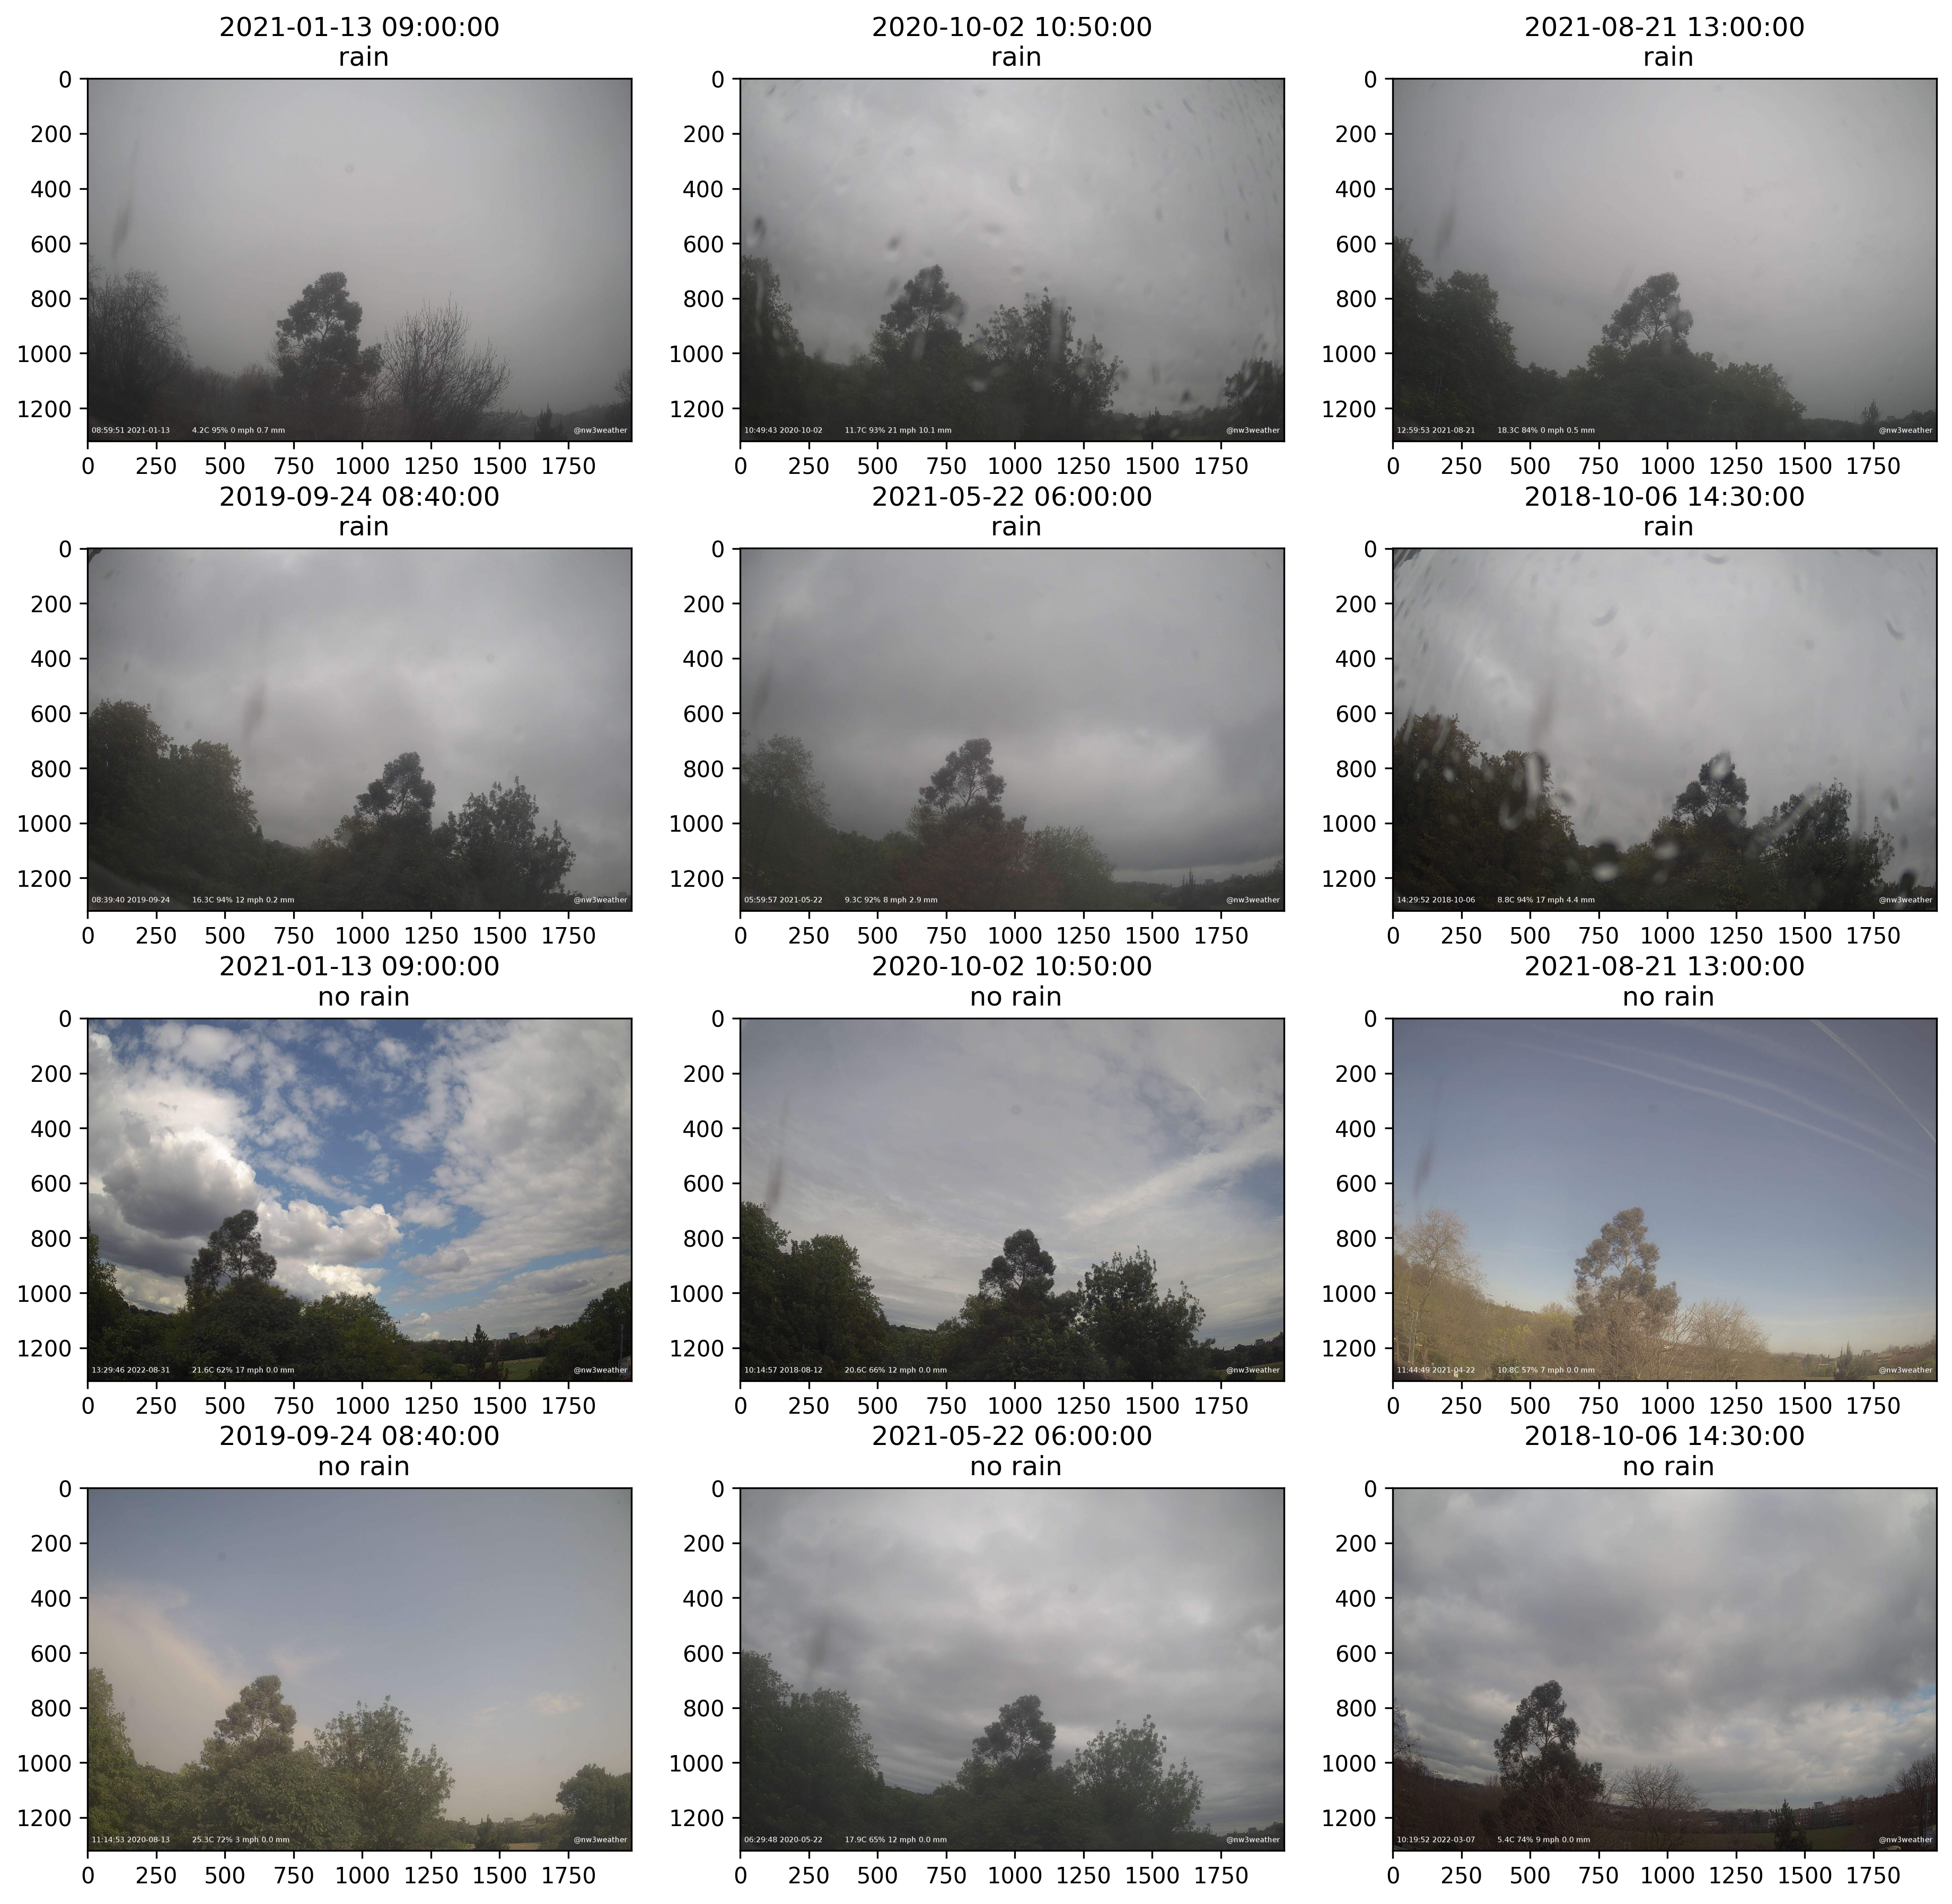

In [14]:
## takes 30s to run this cell
plt.figure(figsize=(15, 15), dpi=300)
tmp=data_rain.sample(6)
tmp2=data_no_rain.sample(6)
for k in range(6):
    plt.subplot(4,3,k+1)
    plt.imshow(plt.imread(tmp.iloc[k,-1]))
    plt.title(str(tmp.iloc[k,0]) +"\n rain")
    plt.subplot(4,3,k+7)
    plt.imshow(plt.imread(tmp2.iloc[k,-1]))
    plt.title(str(tmp.iloc[k,0]) +"\n no rain")
plt.show()

## Save rain images in an extra folder

In [ ]:
# import shutil
# !mkdir ./colab_directory/RainImages/
# for k in range(len(data_rain)):
#    shutil.copyfile(data_rain.iloc[k,-1], "./colab_directory/RainImages/"+data_rain.iloc[k,-1][25:])

## Optional: Merge second weather data set with data frame

In [ ]:
w_data=w_data.reset_index()
w_data_h=w_data.groupby(pd.Grouper(key='datetime', axis=0, freq='1H')).mean().reset_index()

In [ ]:
data_hour=w2_data.merge(data, on='datetime')
data_rain=data_hour[data_hour["precipitation (mm)"]>0]

## Extract Subimages

In [ ]:
def subimages(n_rows,n_col,file,save):
    step_r=int(500/n_rows)
    step_c=int(1980/n_col)
    image=plt.imread(file)
    image_list=[]
    z=1
    for k in range(n_rows):
        for j in range(n_col):
            subimage=image[k*step_r:(k+1)*step_r,j*step_c:(j+1)*step_c,:]
            image_list.append(subimage) 
            if save==True:
                if z<10:
                    imsave("./colab_directory/Subimages/"+file[25:-4]+f"_0{z}.jpg",subimage)
                else:
                    imsave("./colab_directory/Subimages/"+file[25:-4]+f"_{z}.jpg",subimage)
            z=z+1
    return image_list

In [ ]:
#!mkdir ./colab_directory/Subimages/
#
#for k in range(10):
#    image_list=subimages(2,5,f_data.iloc[k,-1],True)

In [15]:
!ls ./colab_directory/Subimages/

2018_07_01_0545_01.jpg	2018_07_01_0610_05.jpg	2018_07_01_0630_09.jpg
2018_07_01_0545_02.jpg	2018_07_01_0610_06.jpg	2018_07_01_0630_10.jpg
2018_07_01_0545_03.jpg	2018_07_01_0610_07.jpg	2018_07_01_0640_01.jpg
2018_07_01_0545_04.jpg	2018_07_01_0610_08.jpg	2018_07_01_0640_02.jpg
2018_07_01_0545_05.jpg	2018_07_01_0610_09.jpg	2018_07_01_0640_03.jpg
2018_07_01_0545_06.jpg	2018_07_01_0610_10.jpg	2018_07_01_0640_04.jpg
2018_07_01_0545_07.jpg	2018_07_01_0615_01.jpg	2018_07_01_0640_05.jpg
2018_07_01_0545_08.jpg	2018_07_01_0615_02.jpg	2018_07_01_0640_06.jpg
2018_07_01_0545_09.jpg	2018_07_01_0615_03.jpg	2018_07_01_0640_07.jpg
2018_07_01_0545_10.jpg	2018_07_01_0615_04.jpg	2018_07_01_0640_08.jpg
2018_07_01_0550_01.jpg	2018_07_01_0615_05.jpg	2018_07_01_0640_09.jpg
2018_07_01_0550_02.jpg	2018_07_01_0615_06.jpg	2018_07_01_0640_10.jpg
2018_07_01_0550_03.jpg	2018_07_01_0615_07.jpg	2018_07_01_0645_01.jpg
2018_07_01_0550_04.jpg	2018_07_01_0615_08.jpg	2018_07_01_0645_02.jpg
2018_07_01_0550_05.jpg	2018_07_01_